# Twitter Sentiment Analysis Pytorch

In [1]:
import pandas as pd
import csv
import re
import torch
from nltk.corpus import stopwords
from gensim.parsing.porter import PorterStemmer
from gensim.utils import tokenize
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torchtext import data
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()
%matplotlib inline

Loading BokehJS ...

## Loading the data

In [2]:
df = pd.read_csv('.pytorch/tweets/tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Exploring features

In [3]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [4]:
df.groupby('airline_sentiment').describe()

tweet_id                                            \
                     count          mean           std           min   
airline_sentiment                                                      
negative            9178.0  5.692602e+17  7.572474e+14  5.675900e+17   
neutral             3099.0  5.691841e+17  8.068405e+14  5.675883e+17   
positive            2363.0  5.691006e+17  8.112476e+14  5.676555e+17   

                                                                           \
                            25%           50%           75%           max   
airline_sentiment                                                           
negative           5.686511e+17  5.695355e+17  5.698798e+17  5.703106e+17   
neutral            5.684852e+17  5.693080e+17  5.699305e+17  5.703093e+17   
positive           5.684331e+17  5.691980e+17  5.698788e+17  5.703093e+17   

                  airline_sentiment_confidence            ...  \
                                         count      mean  ...   
airline_sentiment                                         ...   
negative                                9178.0  0.933365  ...   
neutral                                 3099.0  0.823303  ...   
positive                                2363.0  0.872039  ...   

                  negativereason_confidence      retweet_count            \
                                        75%  max         count      mean   
airline_sentiment                                                          
negative                                1.0  1.0        9178.0  0.093375   
neutral                                 0.0  0.0        3099.0  0.060987   
positive                                0.0  0.0        2363.0  0.069403   

                                                       
                        std  min  25%  50%  75%   max  
airline_sentiment                                      
negative           0.792865  0.0  0.0  0.0  0.0  44.0  
neutral            0.658037  0.0  0.0  0.0  0.0  28.0  
positive           0.659914  0.0  0.0  0.0  0.0  22.0  

[3 rows x 32 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [6]:
df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [7]:
df[df.duplicated('text')]

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
331,568605449659895808,positive,0.6482,NaN,NaN,Virgin America,NaN,SuuperG,NaN,0,@VirginAmerica Thanks!,NaN,2015-02-19 18:57:58 -0800,Wandering So-Cal-ian,Pacific Time (US & Canada)
515,570299889688702976,positive,0.6634,NaN,NaN,United,NaN,nydia376,NaN,0,@united thanks,NaN,2015-02-24 11:11:04 -0800,USA,NaN
1477,569705563287896064,positive,0.6629,NaN,NaN,United,NaN,tiamariaroxs,NaN,0,@united thank you!,NaN,2015-02-22 19:49:25 -0800,NaN,NaN
1864,569545805826166784,positive,0.3512,NaN,0.0000,United,NaN,worldknits,NaN,0,@united thank you,NaN,2015-02-22 09:14:36 -0800,"Fredericksburg, VA",Eastern Time (US & Canada)
1938,569513703722393601,positive,1.0000,NaN,NaN,United,NaN,Angry_VBK,NaN,0,@united thank you,NaN,2015-02-22 07:07:02 -0800,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,569680231012773888,negative,1.0000,Customer Service Issue,1.0000,American,NaN,LBernieMeyer,NaN,0,@AmericanAir 800 number will not even let you...,NaN,2015-02-22 18:08:45 -0800,NaN,NaN
14386,569622568459636736,negative,1.0000,Customer Service Issue,0.6398,American,NaN,SchrierCar,NaN,0,@AmericanAir I want to speak to a human being!...,NaN,2015-02-22 14:19:38 -0800,NaN,NaN
14392,569621879633391616,negative,1.0000,Customer Service Issue,1.0000,American,NaN,salitron78,NaN,0,@AmericanAir no response to DM or email yet. ...,NaN,2015-02-22 14:16:53 -0800,on @TheJR,Seoul
14543,569601363799359488,negative,1.0000,Flight Attendant Complaints,1.0000,American,NaN,stevereasnors,NaN,0,@AmericanAir should reconsider #usairways acqu...,NaN,2015-02-22 12:55:22 -0800,Los Angeles,Pacific Time (US & Canada)


In [8]:
df.drop_duplicates('text', inplace=True)
df[df.duplicated('text')]

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone


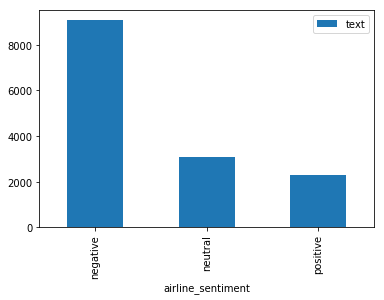

In [34]:
df[['airline_sentiment', 'text']].groupby('airline_sentiment').count().plot.bar()